# Imports

In [90]:
try:
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN
    print("Library is already installed.")
except ImportError:
    print("Library is not installed. Proceed with installation.")
    !pip install fancyimpute
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import re

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="'verbose' argument is deprecated.*")

Library is already installed.


### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/sample_submission.csv'))
df_data: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/data.csv'), index_col='id')
df_train = df_data[~df_data['x_e_out [-]'].isna()]
df_test = df_data[df_data['x_e_out [-]'].isna()]
df_og: pd.DataFrame = pd.read_csv(get_full_dir('input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv'), index_col='id')

In [4]:
def remove_special_characters(column_name):
    return re.sub(r"[^a-zA-Z0-9_]+", "", column_name)

def remove_special_characters_from_dataframe(df):
    df.columns = [remove_special_characters(col) for col in df.columns]
    return df

In [5]:
df_data = remove_special_characters_from_dataframe(df_data)
df_train = remove_special_characters_from_dataframe(df_train)
df_test = remove_special_characters_from_dataframe(df_test)
df_og = remove_special_characters_from_dataframe(df_og)

In [6]:
train = pd.DataFrame(df_train.isna().sum() * 100 / df_train.count())
train['dataset'] = 'train'

test = pd.DataFrame(df_test.isna().sum() * 100 / df_test.count())
test['dataset'] = 'test'

og = pd.DataFrame(df_og.isna().sum() * 100 / df_og.count())
og['dataset'] = 'original'

df_tmp = pd.concat([train, test, og], axis=0)
df_tmp = df_tmp.replace(np.inf, 100)
df_tmp = df_tmp.rename(columns={0: 'NaN Percentage %', 'dataset': 'Data Set'})
df_tmp['Column'] = df_tmp.index

[]

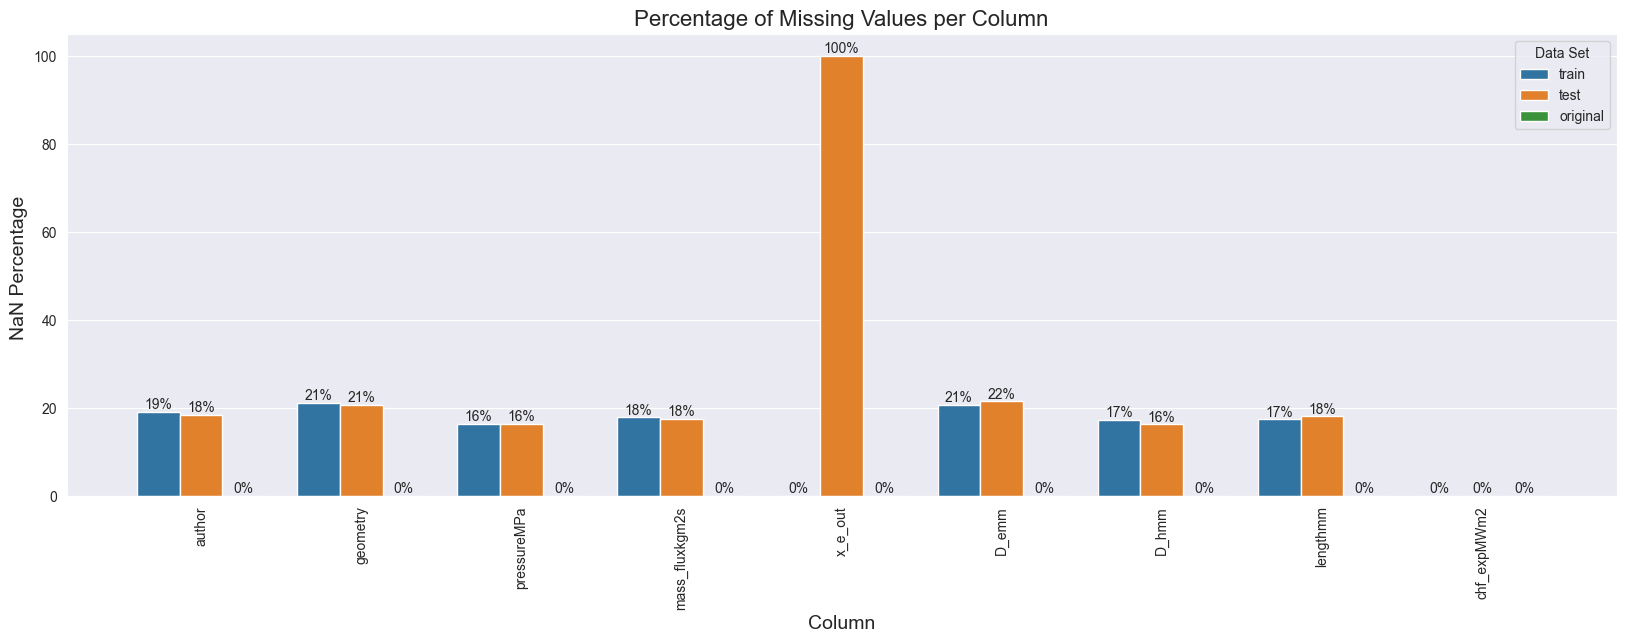

In [7]:
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=df_tmp, y='NaN Percentage %', x="Column", hue="Data Set", orient='v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f') + '%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
plt.xlabel('Column', fontsize=14)
plt.ylabel('NaN Percentage ', fontsize=14)
plt.title('Percentage of Missing Values per Column', fontsize=16)
plt.plot()

##### Our training data contains lots of missing values, we could impute them using a very simple strategy like mean or median however this will likely result is poor model quality due to the about of missing value. Instead, we can also predict what value the missing value should have based off the other non-null value in these columns.

In [8]:
df_sample_submission.head()

,id,x_e_out [-]
0,4,0.0
1,7,0.0
2,10,0.0
3,12,0.0
4,23,0.0


##### As describe in the completions we are prediction the missing values for x_e_out, our test data consist of all the row with missing x_e_out.

In [9]:
df_data.head()

,author,geometry,pressureMPa,mass_fluxkgm2s,x_e_out,D_emm,D_hmm,lengthmm,chf_expMWm2
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [10]:
df_og.head()

,author,geometry,pressureMPa,mass_fluxkgm2s,x_e_out,D_emm,D_hmm,lengthmm,chf_expMWm2
id,,,,,,,,,
1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


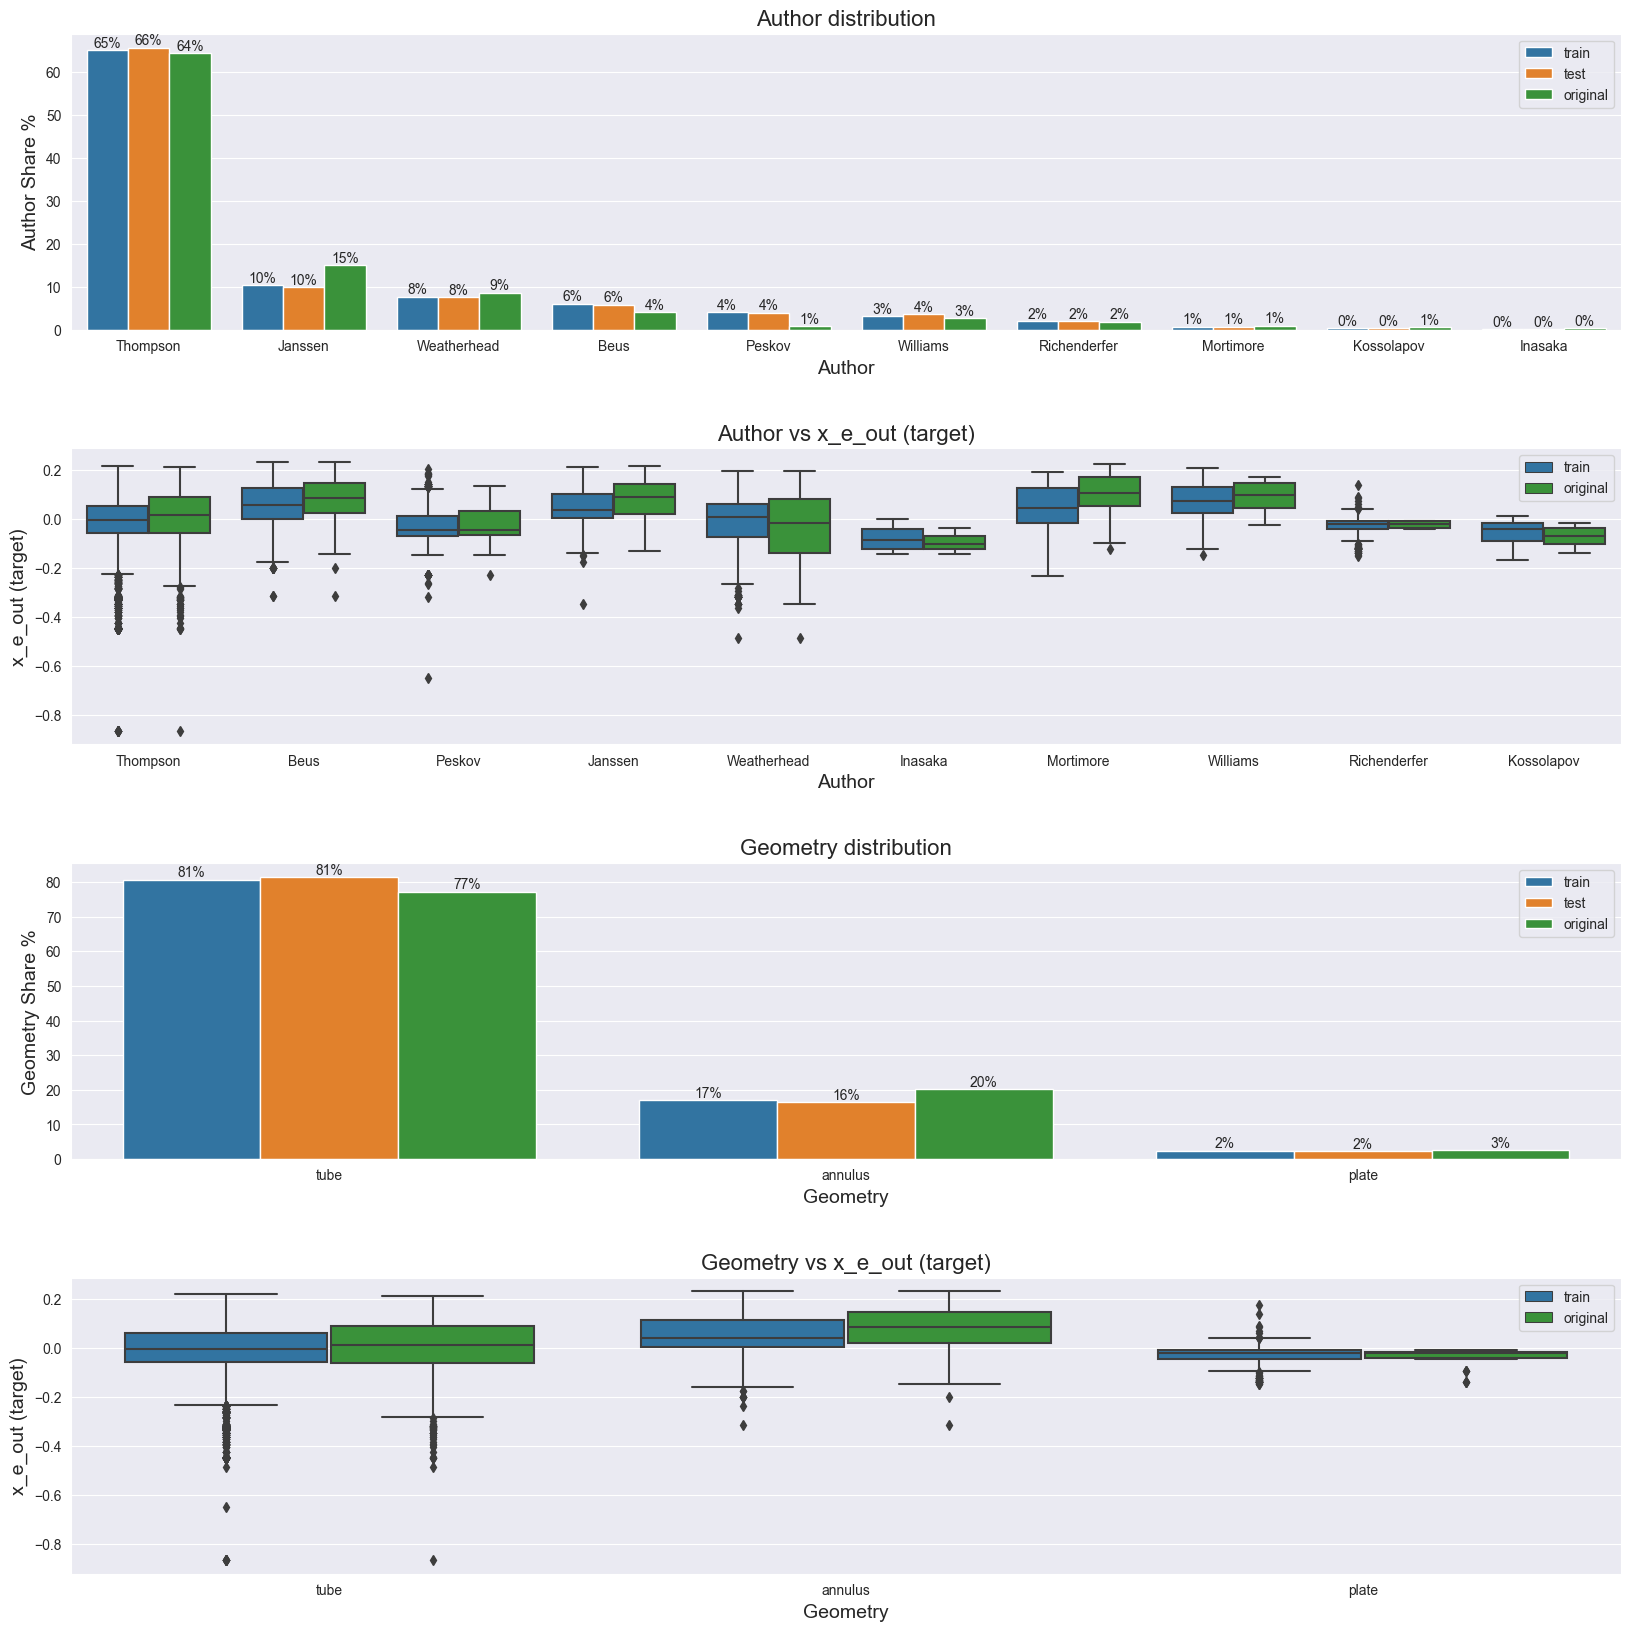

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

def graph_categorical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int,
                              x_label: list[str] = ('x', 'x'), y_label: list[str] = ('y', 'y'), title: list[str]=None, colors: list[str] = None) -> None:

    # Plot barplots
    df_tmp = pd.DataFrame({})
    for df, column, label in data:
        df_tmp_local = pd.DataFrame(df[column].value_counts() * 100 / df[column].count())
        df_tmp_local['dataset'] = label
        df_tmp = pd.concat([df_tmp, df_tmp_local], axis=0)
    df_tmp['x'] = df_tmp.index
    df_tmp = df_tmp.rename(columns={column: 'y', 'dataset': 'Data Set'})
    sns.barplot(data=df_tmp, y='y', x="x", hue="Data Set", orient='v', ax=axes[axes_start_i])
    #axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    for p in axes[i].patches:
        axes[i].annotate(format(p.get_height(), '.0f') + '%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 5),
                    textcoords = 'offset points')
    axes[axes_start_i].set_xlabel(x_label[0], fontsize=14)
    axes[axes_start_i].set_ylabel(y_label[0], fontsize=14)
    if title is not None:
        axes[axes_start_i].set_title(title[0], fontsize=16)

    df_tmp = pd.DataFrame({})
    for df, column, label in data:
        if label != 'test':
            df_tmp_local = df.loc[:, [column, target]]
            df_tmp_local['dataset'] = label
            df_tmp = pd.concat([df_tmp, df_tmp_local], axis=0)
    df_tmp = df_tmp.rename(columns={column: 'c', 'dataset': 'Data Set'})
    if colors is not None:
        sns.boxplot(x='c', y=target, data=df_tmp, orient='v', hue="Data Set", ax=axes[axes_start_i + 1], palette=colors)
    else:
        sns.boxplot(x='c', y=target, data=df_tmp, orient='v', hue="Data Set", ax=axes[axes_start_i + 1])
    axes[axes_start_i + 1].set_xlabel(x_label[1], fontsize=14)
    axes[axes_start_i + 1].set_ylabel(y_label[1], fontsize=14)
    if title is not None:
        axes[axes_start_i + 1].set_title(title[1], fontsize=16)

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()

i = 0
graph_categorical_feature([(df_train, 'author', 'train'), (df_test, 'author', 'test'), (df_og, 'author', 'original')], 'x_e_out', i, x_label=['Author', 'Author'], y_label=['Author Share %', 'x_e_out (target)'], title=['Author distribution', 'Author vs x_e_out (target)'], colors=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
i += 2
graph_categorical_feature([(df_train, 'geometry', 'train'), (df_test, 'geometry', 'test'), (df_og, 'geometry', 'original')], 'x_e_out', i, x_label=['Geometry', 'Geometry'], y_label=['Geometry Share %', 'x_e_out (target)'], title=['Geometry distribution', 'Geometry vs x_e_out (target)'], colors=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
plt.show()

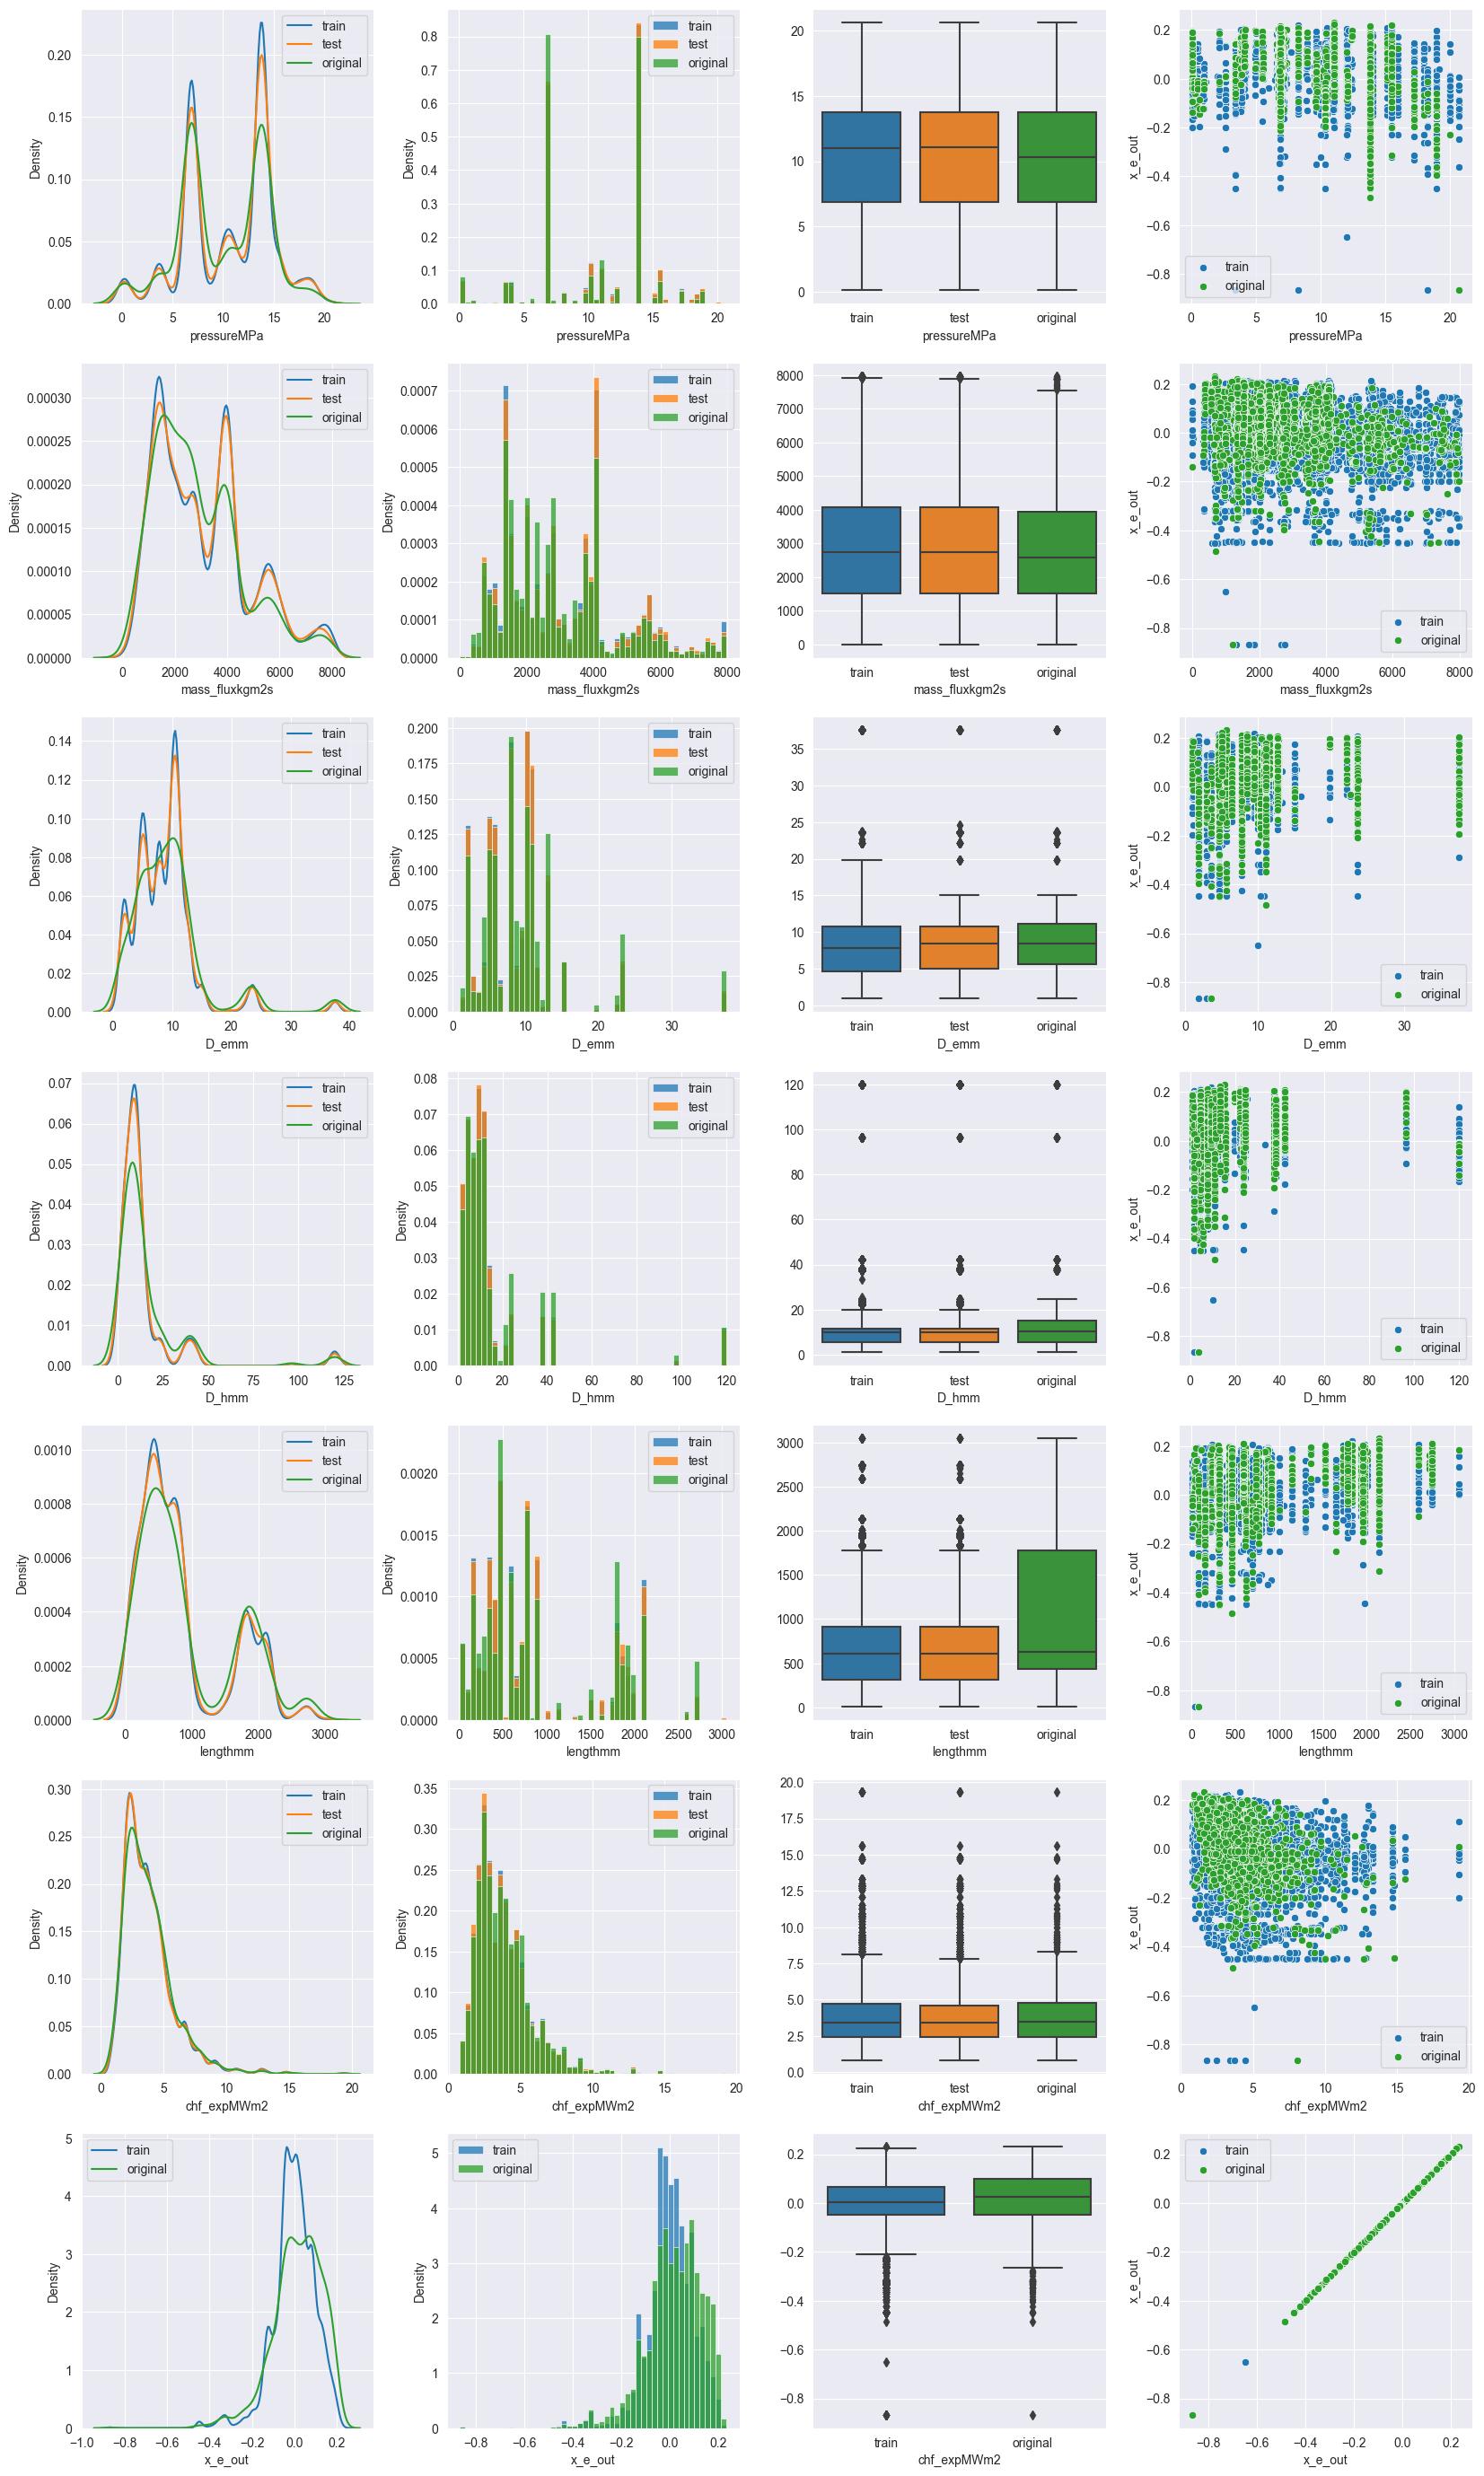

In [12]:
fig, axes = plt.subplots(nrows=len(df_data.columns) - 2, ncols=4, figsize=(20, 35))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
axes = axes.flatten()

def graph_numerical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int, palette=sns.color_palette("tab10")) -> None:
    # Plot densities
    for e, cd in enumerate(data):
        df, column, label = cd
        sns.kdeplot(df[column], label=label, ax=axes[axes_start_i], fill=False, color=palette[e])
    for e, cd in enumerate(data):
        df, column, label = cd
        sns.histplot(df[column], label=label, ax=axes[axes_start_i + 1], stat="density", bins=50, color=palette[e])

    # Plot boxplot
    tmp_data_dict = {}
    for df, column, label in data:
        tmp_data_dict[label] = df[column]
    df_tmp = pd.DataFrame(tmp_data_dict)
    sns.boxplot(data=df_tmp, ax=axes[axes_start_i + 2], palette=palette)
    axes[axes_start_i + 2].set_xlabel(col)

    # Plot target correlation
    for e, cd in enumerate(data):
        df, column, label = cd
        if column != 'test':
            sns.scatterplot(x=column, y=target, label=label, ax=axes[axes_start_i + 3], data=df, color=palette[e])

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 3].legend()

i = 0
for col in df_data.columns:
    if pd.api.types.is_numeric_dtype(df_data[col]):
        if col != 'x_e_out':
            graph_numerical_feature([(df_train, col, 'train'), (df_test, col, 'test'), (df_og, col, 'original')], 'x_e_out', i)
            i += 4
graph_numerical_feature([(df_train, 'x_e_out', 'train'), (df_og, 'x_e_out', 'original')], 'x_e_out', i, palette=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
plt.show()

##### The original data closely follows the distribution of our given synthetic data. This suggesting the value where nulled in our given data set evenly across all features, this means that original data should be good to use without introduction feature or distribution bias.

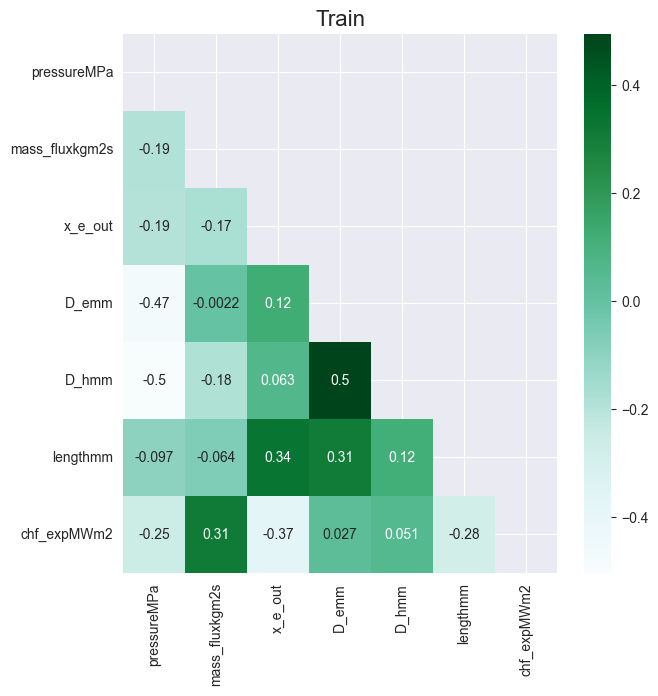

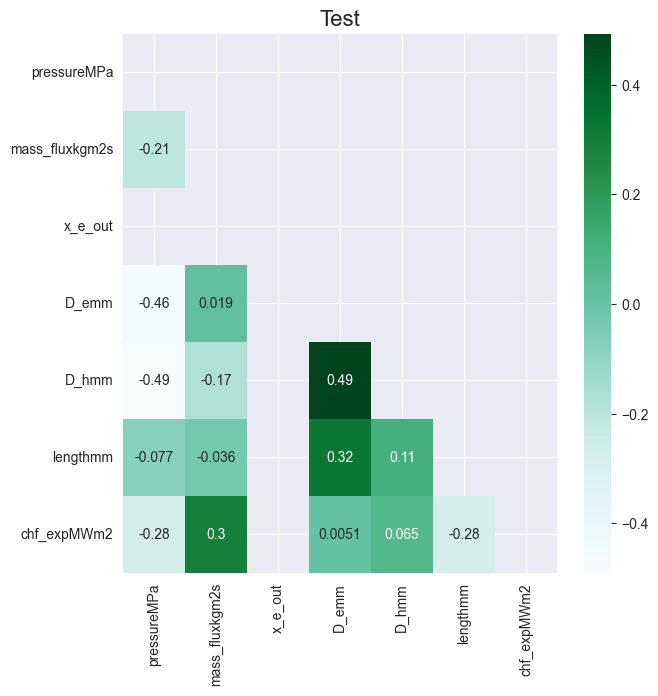

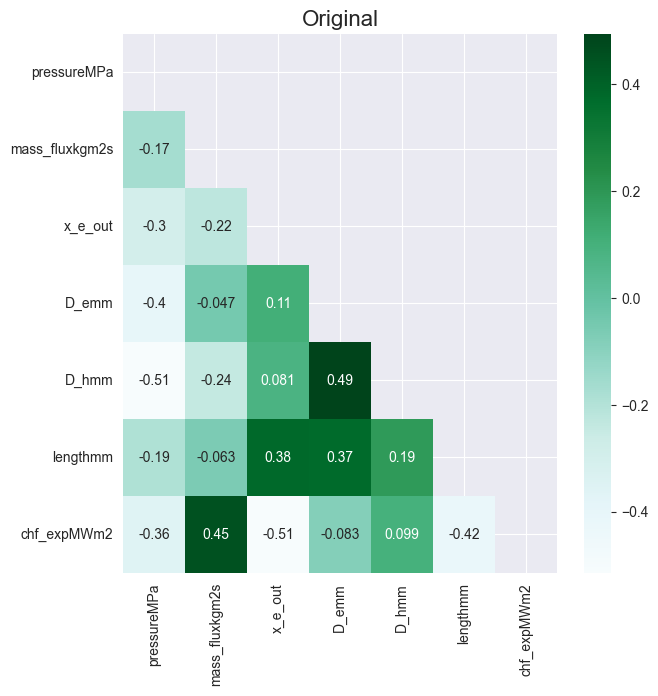

In [13]:
def show_feature_correlation(df: pd.DataFrame, title: str):
    plt.figure(figsize=(7, 7))
    corr_matrix = df.select_dtypes(include='number').corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, cmap='BuGn', annot=True, mask=mask)
    plt.title(title, fontsize=16)
    plt.yticks(rotation=360) # I don't know why rotating by 360 as an effect of 90 degree ration, 90-degree rotation had no effect
    plt.show()

show_feature_correlation(df_train, "Train")
show_feature_correlation(df_test, "Test")
show_feature_correlation(df_og, "Original")

# Data Prep

In [14]:
numerical_columns = ['pressureMPa', 'mass_fluxkgm2s','x_e_out', 'D_emm', 'D_hmm', 'lengthmm', 'chf_expMWm2']
numerical_features = ['pressureMPa', 'mass_fluxkgm2s', 'D_emm', 'D_hmm', 'lengthmm', 'chf_expMWm2']
categorical_columns = ['author', 'geometry']
target = 'x_e_out'

In [15]:
label_encoders = {}

def label_encode(df: pd.DataFrame) -> None:
    for column in categorical_columns:
        label_encoder: LabelEncoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
        label_encoders[column] = label_encoder

def reverse_encode(df: pd.DataFrame) -> None:
    for column in label_encoders.keys():
        df[column] = df[column].astype(int)
        df[column] = label_encoders[column].inverse_transform(df[column])

def one_hot_encode(df: pd.DataFrame) -> pd.DataFrame:
    one_hot_encoded_data = pd.get_dummies(df, columns=categorical_columns)
    return one_hot_encoded_data

def normalize(df: pd.DataFrame) -> pd.DataFrame:
    for column in numerical_features:
        column_values = df[column].values  # No need to reshape column values
        not_nan_values = column_values[~pd.isnull(column_values)]  # Filter non-NaN values

        if not_nan_values.size > 0:  # Check if there are any non-NaN values
            not_nan_values = not_nan_values.reshape(-1, 1)  # Reshape to 2D array with single column
            standard_scaler = StandardScaler()
            normalized_values = standard_scaler.fit_transform(not_nan_values)

            # Create a mask to identify non-NaN values in the column
            mask = ~pd.isnull(df[column])
            df.loc[mask, column] = normalized_values.flatten()

    return df

In [16]:
df_combined: pd.DataFrame = pd.concat([df_data, df_og])
df_combined.reset_index(inplace=True, drop=True)

In [17]:
df_combined = normalize(df_combined)
#label_encode(df_combined)
df_combined = one_hot_encode(df_combined)
df_combined

,pressureMPa,mass_fluxkgm2s,x_e_out,D_emm,D_hmm,lengthmm,chf_expMWm2,author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
0,-0.830902,0.404113,0.1754,NaN,-0.175731,-0.600507,-0.100901,0,0,0,0,0,0,0,1,0,0,0,0,1
1,NaN,1.691601,-0.0416,0.306885,-0.200815,-0.112494,-1.008131,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.736130,-0.576615,0.0335,-0.186164,-0.331250,-0.563536,0.100706,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.736130,0.352704,-0.0279,-0.584395,0.045006,1.916454,-0.856926,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.736130,-1.338148,NaN,0.458592,-0.160681,-0.563536,-1.512147,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33504,-2.213306,-0.878291,-0.0218,1.198165,5.302565,-1.224571,-0.000098,0,0,0,0,0,0,1,0,0,0,0,1,0
33505,-2.213306,-0.878291,-0.0434,1.198165,5.302565,-1.224571,-0.151303,0,0,0,0,0,0,1,0,0,0,0,1,0
33506,-2.213306,-0.595823,-0.0109,1.198165,5.302565,-1.224571,-0.856926,0,0,0,0,0,0,1,0,0,0,0,1,0
33507,-2.213306,-0.595823,-0.0218,1.198165,5.302565,-1.224571,1.108739,0,0,0,0,0,0,1,0,0,0,0,1,0


## Impute missing numerical features

In [18]:
df_combined.isna().sum()

pressureMPa             4452
mass_fluxkgm2s          4791
x_e_out                10415
D_emm                   5488
D_hmm                   4589
lengthmm                4759
chf_expMWm2                0
author_Beus                0
author_Inasaka             0
author_Janssen             0
author_Kossolapov          0
author_Mortimore           0
author_Peskov              0
author_Richenderfer        0
author_Thompson            0
author_Weatherhead         0
author_Williams            0
geometry_annulus           0
geometry_plate             0
geometry_tube              0
dtype: int64

In [19]:
imputer = IterativeSVD()
#imputer = KNN()

columns = list(df_combined.columns.values)
columns.remove('x_e_out')

df_combined_imputed = df_combined.copy()
df_combined_imputed[columns] = imputer.fit_transform(df_combined[columns])

[IterativeSVD] Iter 1: observed MAE=0.272959
[IterativeSVD] Iter 2: observed MAE=0.236218
[IterativeSVD] Iter 3: observed MAE=0.160362
[IterativeSVD] Iter 4: observed MAE=0.055431
[IterativeSVD] Iter 5: observed MAE=0.035047
[IterativeSVD] Iter 6: observed MAE=0.035179
[IterativeSVD] Iter 7: observed MAE=0.035280
[IterativeSVD] Iter 8: observed MAE=0.035351
[IterativeSVD] Iter 9: observed MAE=0.035393
[IterativeSVD] Iter 10: observed MAE=0.035411
[IterativeSVD] Iter 11: observed MAE=0.035409
[IterativeSVD] Iter 12: observed MAE=0.035389
[IterativeSVD] Iter 13: observed MAE=0.035355
[IterativeSVD] Iter 14: observed MAE=0.035309
[IterativeSVD] Iter 15: observed MAE=0.035254
[IterativeSVD] Iter 16: observed MAE=0.035192
[IterativeSVD] Iter 17: observed MAE=0.035124
[IterativeSVD] Iter 18: observed MAE=0.035051
[IterativeSVD] Iter 19: observed MAE=0.034974
[IterativeSVD] Iter 20: observed MAE=0.034895
[IterativeSVD] Iter 21: observed MAE=0.034815
[IterativeSVD] Iter 22: observed MAE=0.0347

In [20]:
df_combined_imputed.isna().sum()

pressureMPa                0
mass_fluxkgm2s             0
x_e_out                10415
D_emm                      0
D_hmm                      0
lengthmm                   0
chf_expMWm2                0
author_Beus                0
author_Inasaka             0
author_Janssen             0
author_Kossolapov          0
author_Mortimore           0
author_Peskov              0
author_Richenderfer        0
author_Thompson            0
author_Weatherhead         0
author_Williams            0
geometry_annulus           0
geometry_plate             0
geometry_tube              0
dtype: int64

In [21]:
for column in numerical_features:
    if df_train[column].isna().sum() > 0:
        df_combined_imputed[f'{column}_was_an'] = df_combined[column].isna().astype(int)

In [22]:
df_combined_imputed

,pressureMPa,mass_fluxkgm2s,x_e_out,D_emm,D_hmm,lengthmm,chf_expMWm2,author_Beus,author_Inasaka,author_Janssen,...,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube,pressureMPa_was_an,mass_fluxkgm2s_was_an,D_emm_was_an,D_hmm_was_an,lengthmm_was_an
0,-0.830902,0.404113,0.1754,-0.292753,-0.175731,-0.600507,-0.100901,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,1,0,0
1,-0.730520,1.691601,-0.0416,0.306885,-0.200815,-0.112494,-1.008131,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0
2,0.736130,-0.576615,0.0335,-0.186164,-0.331250,-0.563536,0.100706,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
3,0.736130,0.352704,-0.0279,-0.584395,0.045006,1.916454,-0.856926,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0
4,0.736130,-1.338148,NaN,0.458592,-0.160681,-0.563536,-1.512147,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33504,-2.213306,-0.878291,-0.0218,1.198165,5.302565,-1.224571,-0.000098,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0
33505,-2.213306,-0.878291,-0.0434,1.198165,5.302565,-1.224571,-0.151303,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0
33506,-2.213306,-0.595823,-0.0109,1.198165,5.302565,-1.224571,-0.856926,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0
33507,-2.213306,-0.595823,-0.0218,1.198165,5.302565,-1.224571,1.108739,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0


In [23]:
df_train = df_combined_imputed[~df_combined_imputed[target].isna()]
df_train, df_holdout = train_test_split(df_train, test_size=0.2, random_state=1)
df_test = df_combined_imputed[df_combined_imputed[target].isna()]

In [24]:
df_train

,pressureMPa,mass_fluxkgm2s,x_e_out,D_emm,D_hmm,lengthmm,chf_expMWm2,author_Beus,author_Inasaka,author_Janssen,...,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube,pressureMPa_was_an,mass_fluxkgm2s_was_an,D_emm_was_an,D_hmm_was_an,lengthmm_was_an
14546,0.695538,-1.399161,-0.4505,-0.755066,-0.481753,-0.769093,-0.655319,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0
1354,0.736130,0.557775,-0.2001,-1.286041,-0.622222,-1.014578,0.856730,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0
29688,-0.870135,0.565684,0.0049,3.234795,-0.175731,3.268100,-0.756123,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,1,0,0
30121,0.736130,1.775776,0.0468,-0.755066,-0.593843,-1.086204,-0.302508,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,1,1
25454,-0.856288,-0.287874,0.1004,0.762007,1.404547,0.957217,-0.655319,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16398,-0.856288,-0.959641,-0.0512,5.464930,1.163743,1.648786,0.806329,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0
25812,0.736130,-0.959641,0.0905,-0.167200,-0.326234,-0.365373,-0.907328,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0
7740,-0.863212,1.835578,-0.0443,0.401702,-0.175731,-0.919933,0.050304,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,1,0,0,0
18199,-0.060079,1.215959,-0.1272,0.306885,0.121057,-0.112494,-1.058533,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,1,0,1,0


In [25]:
df_holdout

,pressureMPa,mass_fluxkgm2s,x_e_out,D_emm,D_hmm,lengthmm,chf_expMWm2,author_Beus,author_Inasaka,author_Janssen,...,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube,pressureMPa_was_an,mass_fluxkgm2s_was_an,D_emm_was_an,D_hmm_was_an,lengthmm_was_an
24205,0.610553,0.136333,0.1005,-1.286041,-0.608210,-0.210097,-0.806524,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0
1317,0.736130,2.771757,-0.2001,-0.755066,-0.481753,-0.769093,0.302312,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
32532,0.736130,0.304684,-0.1441,-0.755066,-0.481753,-0.769093,0.503919,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0
25048,-0.990507,-0.392446,0.1354,0.401702,-0.175731,1.314572,-0.655319,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0
27289,-0.847057,0.558340,0.0501,0.401702,-0.813005,1.314572,0.201509,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6450,0.736130,-0.185680,0.0537,0.155178,-0.240949,1.475764,1.461550,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
28292,0.736130,-0.422953,-0.2387,-0.963663,-0.536937,-1.126968,0.403115,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0
30857,-0.856288,-0.200933,-0.0962,0.421567,0.416246,-0.337276,0.705525,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,1,0,0
6909,-0.856288,-0.966985,0.0032,1.053346,0.401196,2.817058,0.302312,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0


In [26]:
df_test

,pressureMPa,mass_fluxkgm2s,x_e_out,D_emm,D_hmm,lengthmm,chf_expMWm2,author_Beus,author_Inasaka,author_Janssen,...,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube,pressureMPa_was_an,mass_fluxkgm2s_was_an,D_emm_was_an,D_hmm_was_an,lengthmm_was_an
4,0.736130,-1.338148,NaN,0.458592,-0.160681,-0.563536,-1.512147,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0
7,1.707736,-1.301992,NaN,0.249995,-0.215865,1.200702,0.050304,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0
10,0.592823,0.256134,NaN,-1.286041,-0.622222,-1.014578,-1.008131,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1,1,0,0,0
12,-0.856288,2.511322,NaN,3.949829,-0.075396,1.614773,0.251911,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
23,1.133081,-0.960206,NaN,-0.584395,0.045006,1.916454,-0.756123,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31633,0.099163,0.628649,NaN,0.534446,-0.140614,-0.111541,1.058337,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,1,0,0,1
31634,-2.213306,-0.595823,NaN,1.198165,5.302565,-1.224571,-0.756123,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0
31637,0.736130,-1.337018,NaN,2.436375,-0.160681,-0.563536,-0.453713,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0,0,1,0,0
31640,0.736130,-0.145065,NaN,-0.755066,-0.481753,-0.305486,1.965567,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1


# Train

## Hypermarket search

In [27]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'metric': 'mae',
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'num_leaves': trial.suggest_int('num_leaves', 3, 64),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'force_col_wise': trial.suggest_categorical('force_col_wise', [True, False]),
        'verbosity': -1
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the LGBM regressor
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_lgbm_mae = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_lgbm_mae.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_lgbm_mae.best_params
best_mae = study_lgbm_mae.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-24 02:46:18,407] A new study created in memory with name: no-name-4bf6b0f1-b563-48bf-b8ef-8a26ed916358
[I 2023-05-24 02:46:20,142] Trial 0 finished with value: 0.06081724595319569 and parameters: {'n_estimators': 3642, 'max_depth': 8, 'num_leaves': 49, 'learning_rate': 0.04645112254728892, 'min_child_samples': 20, 'reg_alpha': 0.9516442787600281, 'reg_lambda': 0.8448461015266067, 'force_col_wise': True}. Best is trial 0 with value: 0.06081724595319569.
[I 2023-05-24 02:46:23,459] Trial 1 finished with value: 0.06212872549103476 and parameters: {'n_estimators': 3613, 'max_depth': 13, 'num_leaves': 24, 'learning_rate': 0.019590669446925262, 'min_child_samples': 15, 'reg_alpha': 0.015345806964209285, 'reg_lambda': 0.24096453924408023, 'force_col_wise': True}. Best is trial 0 with value: 0.06081724595319569.
[I 2023-05-24 02:46:29,062] Trial 2 finished with value: 0.06504607872140789 and parameters: {'n_estimators': 4836, 'max_depth': 13, 'num_leaves': 37, 'learning_rate': 0.035

Best Parameters: {'n_estimators': 1660, 'max_depth': 8, 'num_leaves': 7, 'learning_rate': 0.04030156894863998, 'min_child_samples': 18, 'reg_alpha': 0.8194204469236582, 'reg_lambda': 0.598042750381489, 'force_col_wise': False}
Best MAE: 0.06000288411595056


In [28]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'metric': 'RMSE',
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'max_depth': trial.suggest_int('max_depth', 8, 16),
        'num_leaves': trial.suggest_int('num_leaves', 3, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'force_col_wise': trial.suggest_categorical('force_col_wise', [True, False]),
        'verbosity': -1
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the LGBM regressor
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    return rmse

# Create the Optuna study
study_lgbm_rmse = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_lgbm_rmse.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_lgbm_rmse.best_params
best_rmse = study_lgbm_rmse.best_value
print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

[I 2023-05-24 02:48:12,405] A new study created in memory with name: no-name-50d00dac-469d-435a-9fb7-5ccfc24d9bbe
[I 2023-05-24 02:48:14,200] Trial 0 finished with value: 0.08641817213221623 and parameters: {'n_estimators': 4271, 'max_depth': 8, 'num_leaves': 57, 'learning_rate': 0.03008250326216355, 'min_child_samples': 9, 'reg_alpha': 0.900481197334848, 'reg_lambda': 0.32405997315873003, 'force_col_wise': True}. Best is trial 0 with value: 0.08641817213221623.
[I 2023-05-24 02:48:19,454] Trial 1 finished with value: 0.0916558048725817 and parameters: {'n_estimators': 2726, 'max_depth': 10, 'num_leaves': 62, 'learning_rate': 0.026954879562576653, 'min_child_samples': 4, 'reg_alpha': 0.17258453365877968, 'reg_lambda': 0.7769017279624363, 'force_col_wise': True}. Best is trial 0 with value: 0.08641817213221623.
[I 2023-05-24 02:48:23,945] Trial 2 finished with value: 0.09582242645892984 and parameters: {'n_estimators': 2491, 'max_depth': 12, 'num_leaves': 67, 'learning_rate': 0.09035547

Best Parameters: {'n_estimators': 4491, 'max_depth': 14, 'num_leaves': 3, 'learning_rate': 0.09427478239537436, 'min_child_samples': 14, 'reg_alpha': 0.9989156987825982, 'reg_lambda': 0.8671684524455511, 'force_col_wise': False}
Best RMSE: 0.08506955553759461


In [29]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'loss_function': 'MAE',
        'depth': trial.suggest_int('depth', 3, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'iterations': trial.suggest_int('iterations', 500, 5000),
        'early_stopping_rounds': 100,
        'verbose': False
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the CatBoost regressor
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_catboost_mae = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_catboost_mae.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_catboost_mae.best_params
best_mae = study_catboost_mae.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-24 02:50:20,546] A new study created in memory with name: no-name-043f0c0a-c22a-4d0f-9476-d1d8732527cc
[I 2023-05-24 02:51:08,268] Trial 0 finished with value: 0.060842528265613774 and parameters: {'depth': 15, 'learning_rate': 0.0822944550148578, 'l2_leaf_reg': 0.5215288948181874, 'random_strength': 0.7749027958003427, 'bagging_temperature': 0.42446169504257836, 'grow_policy': 'SymmetricTree', 'iterations': 4468}. Best is trial 0 with value: 0.060842528265613774.
[I 2023-05-24 02:51:47,835] Trial 1 finished with value: 0.06083728874823805 and parameters: {'depth': 15, 'learning_rate': 0.1673384619561358, 'l2_leaf_reg': 0.9504349153728248, 'random_strength': 0.5924277773777585, 'bagging_temperature': 0.18380754209870964, 'grow_policy': 'SymmetricTree', 'iterations': 3276}. Best is trial 1 with value: 0.06083728874823805.
[I 2023-05-24 02:51:49,065] Trial 2 finished with value: 0.059693927058038554 and parameters: {'depth': 6, 'learning_rate': 0.11435227275228681, 'l2_leaf_re

Best Parameters: {'depth': 12, 'learning_rate': 0.05323458908723387, 'l2_leaf_reg': 0.7570375313909963, 'random_strength': 0.2685993622755885, 'bagging_temperature': 0.5338415685172834, 'grow_policy': 'Lossguide', 'iterations': 1655}
Best MAE: 0.05930051235765455


In [30]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'loss_function': 'RMSE',
        'depth': trial.suggest_int('depth', 3, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 0.1),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 0.5),
        'grow_policy': 'Lossguide',
        'iterations': trial.suggest_int('iterations', 500, 5000),
        'early_stopping_rounds': 100,
        'verbose': False
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the CatBoost regressor
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    return rmse

# Create the Optuna study
study_catboost_rmse = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_catboost_rmse.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_catboost_rmse.best_params
best_rmse = study_catboost_rmse.best_value
print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

[I 2023-05-24 02:59:43,095] A new study created in memory with name: no-name-18c3668e-9d87-44f9-aede-ab586bb43e40
[I 2023-05-24 02:59:43,946] Trial 0 finished with value: 0.08620978263675691 and parameters: {'depth': 13, 'learning_rate': 0.1818220436944767, 'l2_leaf_reg': 0.9436117574414331, 'random_strength': 0.08203184009542369, 'bagging_temperature': 0.18745871129298747, 'iterations': 1874}. Best is trial 0 with value: 0.08620978263675691.
[I 2023-05-24 02:59:46,679] Trial 1 finished with value: 0.08698966535238287 and parameters: {'depth': 3, 'learning_rate': 0.005357514983256018, 'l2_leaf_reg': 0.6489795599731285, 'random_strength': 2.8185145380121846e-05, 'bagging_temperature': 0.3275246953422197, 'iterations': 1096}. Best is trial 0 with value: 0.08620978263675691.
[I 2023-05-24 02:59:47,798] Trial 2 finished with value: 0.08556147740801932 and parameters: {'depth': 4, 'learning_rate': 0.04473907497185374, 'l2_leaf_reg': 0.48924444952165347, 'random_strength': 0.0288240846929037

Best Parameters: {'depth': 4, 'learning_rate': 0.046611082457781866, 'l2_leaf_reg': 0.9934607490577114, 'random_strength': 0.03570721351874388, 'bagging_temperature': 0.4885642809750214, 'iterations': 3535}
Best RMSE: 0.0854121688929699


In [31]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'grow_policy': 'lossguide',
        'eta': trial.suggest_float('eta', 0.00, 1),
        'early_stopping_rounds': 100,
        'huber_slope': trial.suggest_float('huber_slope', 0.01, 0.5),
        'verbosity': 0
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the XGBoost regressor
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, evals=[(dval, 'validation')], verbose_eval=False)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(dval)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_xgboost_mae = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_xgboost_mae.optimize(objective, n_trials=250)

# Print the best parameters and the best MAE
best_params = study_xgboost_mae.best_params
best_mae = study_xgboost_mae.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-24 03:03:02,048] A new study created in memory with name: no-name-0fa9e844-5ccc-417c-94f8-d4bdc478d010
[I 2023-05-24 03:03:02,142] Trial 0 finished with value: 0.21552484448455633 and parameters: {'n_estimators': 4729, 'max_depth': 7, 'learning_rate': 0.025715647067469045, 'min_child_weight': 2.8468399329145613, 'gamma': 0.489906996511948, 'subsample': 0.5654645609230005, 'colsample_bytree': 0.6315176212857332, 'reg_alpha': 0.7884878455896513, 'reg_lambda': 0.0648548852490366, 'eta': 0.4012867338545788, 'huber_slope': 0.20092943271451452}. Best is trial 0 with value: 0.21552484448455633.
[I 2023-05-24 03:03:02,225] Trial 1 finished with value: 0.22437898877460158 and parameters: {'n_estimators': 1008, 'max_depth': 8, 'learning_rate': 0.022473257952180616, 'min_child_weight': 1.2509909178258718, 'gamma': 0.8056619897142799, 'subsample': 0.6373405432700223, 'colsample_bytree': 0.7633030016537732, 'reg_alpha': 0.5497410830132401, 'reg_lambda': 0.27306305129488695, 'eta': 0.9130

Best Parameters: {'n_estimators': 3904, 'max_depth': 5, 'learning_rate': 0.09991363536896489, 'min_child_weight': 9.77949168915864, 'gamma': 0.21089546896682784, 'subsample': 0.8751389346632088, 'colsample_bytree': 0.9376981476618155, 'reg_alpha': 0.4291873419008898, 'reg_lambda': 0.6998150542397746, 'eta': 0.4337203422326555, 'huber_slope': 0.16434548234059837}
Best MAE: 0.06987790877030607


In [32]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'max_depth': trial.suggest_int('max_depth', 1, 4),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        #'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        #'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        #'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        #'grow_policy': 'lossguide',
        #'eta': trial.suggest_float('eta', 0.00, 1),
        'early_stopping_rounds': 100,
        #'huber_slope': trial.suggest_float('huber_slope', 0.01, 0.1),
        'verbosity': 0
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the XGBoost regressor
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, evals=[(dval, 'validation')], verbose_eval=False)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(dval)
    rmse = mean_squared_error(y_val, y_pred)

    return rmse

# Create the Optuna study
study_xgboost_rmse = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_xgboost_rmse.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_xgboost_rmse.best_params
best_rmse = study_xgboost_rmse.best_value
print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

[I 2023-05-24 03:03:34,436] A new study created in memory with name: no-name-4cc58f76-40a8-48b9-b5fb-97ebd6879804
[I 2023-05-24 03:03:34,483] Trial 0 finished with value: 0.12063972484210352 and parameters: {'n_estimators': 4598, 'max_depth': 3, 'learning_rate': 0.039368155923740725, 'min_child_weight': 0.8963833282781963, 'subsample': 0.9339006947360691, 'colsample_bytree': 0.7321363656781774}. Best is trial 0 with value: 0.12063972484210352.
[I 2023-05-24 03:03:34,546] Trial 1 finished with value: 0.04894829790425801 and parameters: {'n_estimators': 4651, 'max_depth': 3, 'learning_rate': 0.08692228142943098, 'min_child_weight': 6.623713939349779, 'subsample': 0.6823374678870433, 'colsample_bytree': 0.761636653619216}. Best is trial 1 with value: 0.04894829790425801.
[I 2023-05-24 03:03:34,608] Trial 2 finished with value: 0.14948616652985786 and parameters: {'n_estimators': 4688, 'max_depth': 4, 'learning_rate': 0.02825846758740752, 'min_child_weight': 6.554489255257575, 'subsample':

Best Parameters: {'n_estimators': 1919, 'max_depth': 4, 'learning_rate': 0.09997782634413402, 'min_child_weight': 6.702537969648534, 'subsample': 0.9600440337842803, 'colsample_bytree': 0.6856422531455049}
Best RMSE: 0.03853171238286352


## Train models with found hyperspaces

In [40]:
class Pipeline:

    def __init__(self, model_type: str):
        self.model_type = model_type
        if model_type == 'LightGBM_mae':
            self.model = lgb.LGBMRegressor(**study_lgbm_mae.best_params)
        elif model_type == 'CatBoost_mae':
            self.model = CatBoostRegressor(**study_catboost_mae.best_params)
        elif model_type == 'XGBoost_mae':
            self.model = xgb.XGBRegressor(**study_xgboost_mae.best_params)
        elif model_type == 'LightGBM_rmse':
            self.model = lgb.LGBMRegressor(**study_lgbm_rmse.best_params)
        elif model_type == 'CatBoost_rmse':
            self.model = CatBoostRegressor(**study_catboost_rmse.best_params)
        elif model_type == 'XGBoost_rmse':
            self.model = xgb.XGBRegressor(**study_xgboost_rmse.best_params)
        else:
            raise ValueError(f"Given model type is not supported! {model_type} was given.")

    def fit(self, X, y, X_val, y_val):
        if self.model_type in ['CatBoost']:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], early_stopping_rounds=100, verbose=False)
        else:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

    def predict(self, X):
        return self.model.predict(X)

In [34]:
def train(model_type):
    X = df_train.drop(['x_e_out'], axis=1)
    y = df_train['x_e_out']
    SKFs = KFold(n_splits=10, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    idx_vls = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        train_dataframe = df_train.iloc[idx_tr]
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('x_e_out', axis=1)
        y_train = train_dataframe['x_e_out']
        X_dev = dev_dataframe.drop('x_e_out', axis=1)
        y_dev = dev_dataframe['x_e_out']

        # crates and fits a pipeline
        pipelineMy = Pipeline(model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = mean_squared_error(y_dev, pipelineMy.predict(X_dev), squared=False)
        losses.append(loss)
        idx_vls.append(idx_vl)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines, idx_vls

In [35]:
supported_models = ['LightGBM_mae', 'CatBoost_mae', 'XGBoost_mae', 'LightGBM_rmse', 'CatBoost_rmse', 'XGBoost_rmse']

In [ ]:
train_results = {}
for model_name in supported_models:
    print(f"-------------------- {model_name} -------------------- ")
    losses, pipelines, eval_sets = train(model_name)
    train_results[f'{model_name}_losses'] = losses
    train_results[f'{model_name}_pipelines'] = pipelines
    train_results[f'{model_name}_eval_sets'] = eval_sets

# Assembly

In [42]:
df_assembly = pd.DataFrame({})

def make_model_predictions(model_name, X):
    prediction = 0
    for pipeline in train_results[f'{model_name}_pipelines']:
        prediction += pipeline.predict(X)
    return prediction / float(len(train_results[f'{model_name}_pipelines']))

for model_name in supported_models:
    X = df_holdout.drop(target, axis=1)
    df_assembly[model_name] = make_model_predictions(model_name, X)

## Simple weighted assembly

In [84]:
def eval_assembly_on_validation(weights):
    prediction = 0
    for model_id, x in enumerate(df_assembly.columns.values):
        prediction += df_assembly[x] * weights[model_id]

    return mean_squared_error(df_holdout[target], prediction)

In [85]:
# Set initial weights
model_weights = np.array([1/len(df_assembly.columns.values) for i in range(len(df_assembly.columns.values))])
# Define the optimization bounds
bounds = [(0, 1.0)] * len(model_weights)

# Define the optimization function
res = minimize(eval_assembly_on_validation, model_weights, method='nelder-mead', bounds=bounds)
# Print the optimized weights
optimal_model_weights = res.x
print(optimal_model_weights.sum())
optimal_model_weights = optimal_model_weights / np.sum(optimal_model_weights, axis=0, keepdims=True)
print(optimal_model_weights.sum())

1.0538664530478756
1.0538664530478756


In [86]:
df_optimal_model_weights = {'model_name': [], 'weight': []}
for i in range(len(df_assembly.columns.values)):
    df_optimal_model_weights['model_name'].append(df_assembly.columns.values[i])
    df_optimal_model_weights['weight'].append(optimal_model_weights[i])
    print(f"{optimal_model_weights[i]:.3f} {df_assembly.columns.values[i]}")
df_optimal_model_weights = pd.DataFrame(df_optimal_model_weights)

0.046 LightGBM_mae
0.461 CatBoost_mae
0.000 XGBoost_mae
0.131 LightGBM_rmse
0.197 CatBoost_rmse
0.219 XGBoost_rmse


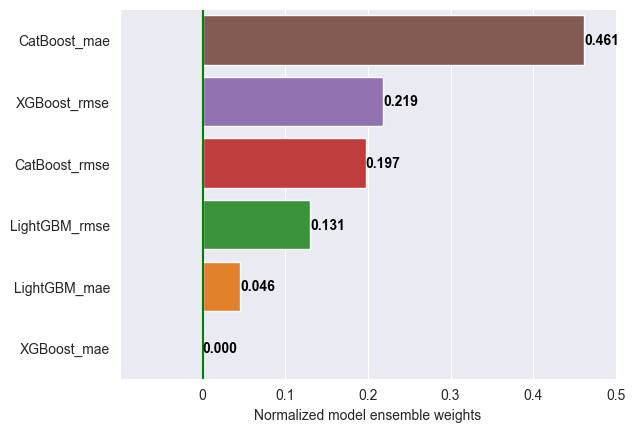

In [87]:
df_optimal_model_weights.sort_values('weight', ascending=True, inplace=True)
ax = sns.barplot(x='weight', y='model_name', data=df_optimal_model_weights, palette=sns.color_palette("tab10"))
ax.set_ylim(ax.get_ylim()[::-1])
for i, v in enumerate(df_optimal_model_weights['weight']):
    ax.text(v, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='left', va='center')
ax.set(ylabel=None)
ax.set(xlabel="Normalized model ensemble weights")
ax.set_xlim([-0.1, None])
ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_xticklabels(['', 0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.axvline(x=0, color='g', linestyle='-')
plt.show()

In [128]:
def make_weighted_assembly_predictions(X):
    df_tmp = pd.DataFrame({})
    for model_name in supported_models:
        df_tmp[model_name] = make_model_predictions(model_name, X)
    prediction = 0
    for model_id, x in enumerate(df_assembly.columns.values):
        prediction += df_tmp[x] * optimal_model_weights[model_id]
    return prediction

In [129]:
print(mean_squared_error(df_holdout[target], make_weighted_assembly_predictions(df_holdout.drop(target, axis=1)), squared=False))

0.08474718043316909


## Stacked assembly

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df_assembly, df_holdout[target], test_size=0.2, random_state=1)
lgbm_blender_model = lgb.LGBMRegressor()
lgbm_blender_model.fit(X_train, y_train)
print(mean_squared_error(y_test, lgbm_blender_model.predict(X_test), squared=False))

0.08306449367515305


In [122]:
def make_stacked_predictions(X):
    df_tmp = pd.DataFrame({})
    for model_name in supported_models:
        df_tmp[model_name] = make_model_predictions(model_name, X)
    return lgbm_blender_model.predict(df_tmp)

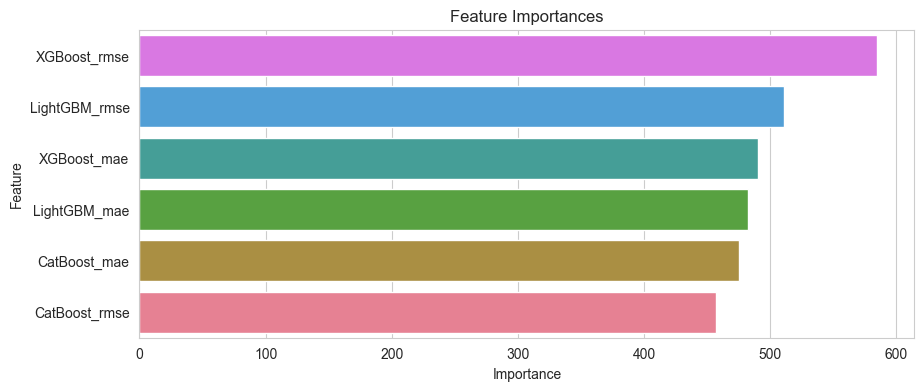

In [137]:
df_importance = pd.DataFrame({'feature': df_assembly.columns.values, 'importance': lgbm_blender_model.feature_importances_})
df_importance = df_importance.sort_values('importance', ascending=False)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 4))
palette = sns.color_palette("husl", len(df_importance))
palette.reverse()
sns.barplot(x="importance", y="feature", data=df_importance, palette=palette)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Models evaluation

In [132]:
performance_data = {'model_name': [], 'loss_og': [], 'loss_given': []}

def make_model_predictions(model_name, X):
    prediction = 0
    for pipeline in train_results[f'{model_name}_pipelines']:
        prediction += pipeline.predict(X)
    return prediction / float(len(train_results[f'{model_name}_pipelines']))

df_holdout_og = df_holdout[df_holdout.index >= 31644]
df_holdout_given = df_holdout[df_holdout.index < 31644]
X_og = df_holdout_og.drop(target, axis=1)
y_og = df_holdout_og[target]
X_given = df_holdout_given.drop(target, axis=1)
y_given = df_holdout_given[target]

for model_name in supported_models:
    performance_data['model_name'].append(model_name)
    performance_data['loss_og'].append(mean_squared_error(y_og, make_model_predictions(model_name, X_og), squared=False))
    performance_data['loss_given'].append(mean_squared_error(y_given, make_model_predictions(model_name, X_given), squared=False))

performance_data['model_name'].append('LGBM Stacking')
performance_data['loss_og'].append(mean_squared_error(y_og, make_stacked_predictions(X_og), squared=False))
performance_data['loss_given'].append(mean_squared_error(y_given, make_stacked_predictions(X_given), squared=False))
performance_data['model_name'].append('Weighted Assembly')
performance_data['loss_og'].append(mean_squared_error(y_og, make_weighted_assembly_predictions(X_og), squared=False))
performance_data['loss_given'].append(mean_squared_error(y_given, make_weighted_assembly_predictions(X_given), squared=False))

performance_data = pd.DataFrame(performance_data)

In [158]:
def graph_model_performance(loss: str, title:str, ax):
    sns.barplot(x=loss, y='model_name', data=performance_data, ax=ax, palette=palette_reversed)
    for i, v in enumerate(performance_data[loss]):
        ax.text(v - 0.003, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='right', va='center')
    ax.set(ylabel=None)
    ax.set(xlabel="RMSE")
    ax.set_title(title)

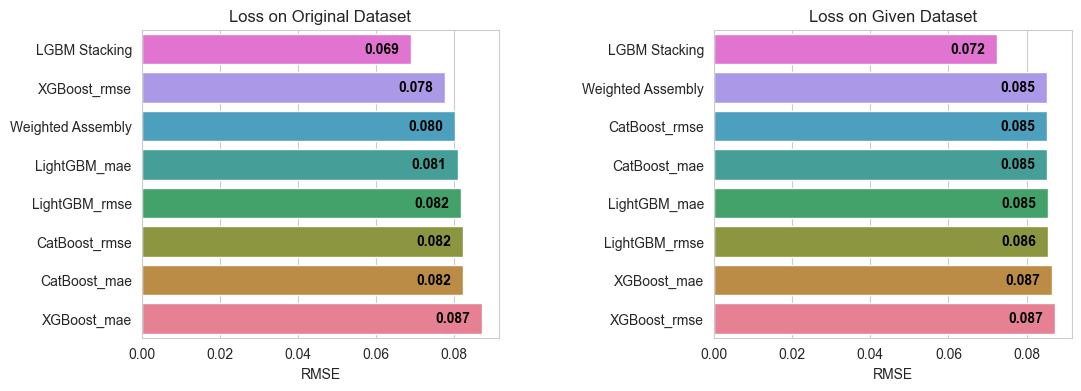

In [159]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.6)
axes = axes.flatten()

palette = sns.color_palette("husl", n_colors=len(performance_data))
palette_reversed = palette[::-1]

performance_data.sort_values('loss_og', ascending=True, inplace=True)
graph_model_performance('loss_og', 'Loss on Original Dataset', axes[0])
performance_data.sort_values('loss_given', ascending=True, inplace=True)
graph_model_performance('loss_given', 'Loss on Given Dataset', axes[1])
plt.show()

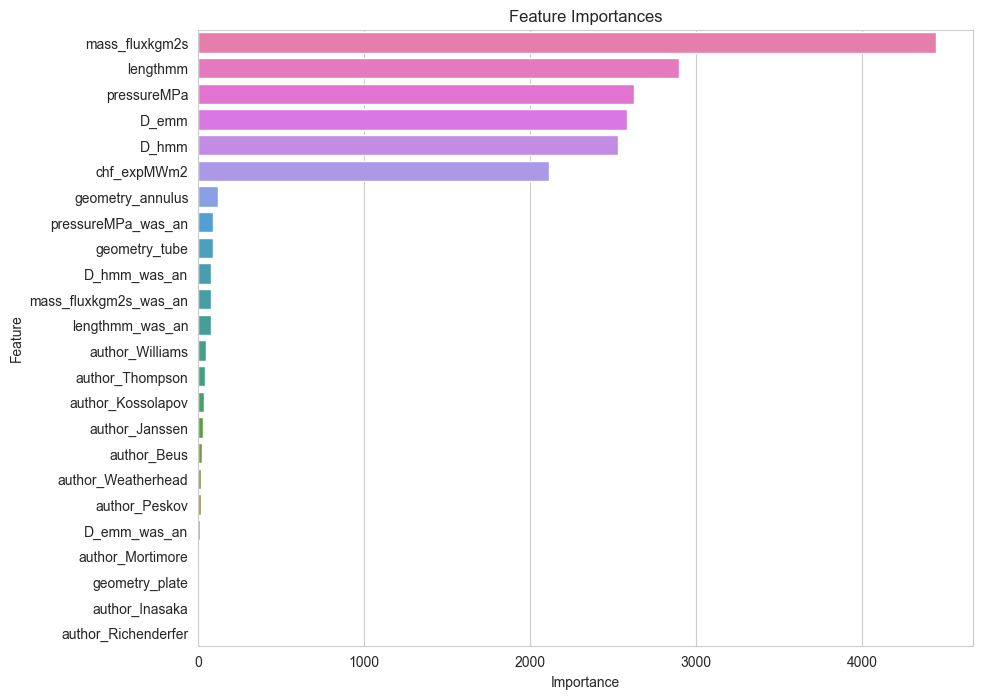

In [172]:
importance = train_results['LightGBM_rmse_pipelines'][0].model.feature_importances_
for i in range(1, len(train_results['LightGBM_rmse_pipelines'])):
    importance += train_results['LightGBM_rmse_pipelines'][i].model.feature_importances_
importance = importance / 5.0
feature_names = df_train.drop('x_e_out', axis=1).columns.values
df_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
df_importance = df_importance.sort_values('importance', ascending=False)


sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
palette = sns.color_palette("husl", len(df_importance))
palette.reverse()
sns.barplot(x="importance", y="feature", data=df_importance, palette=palette)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

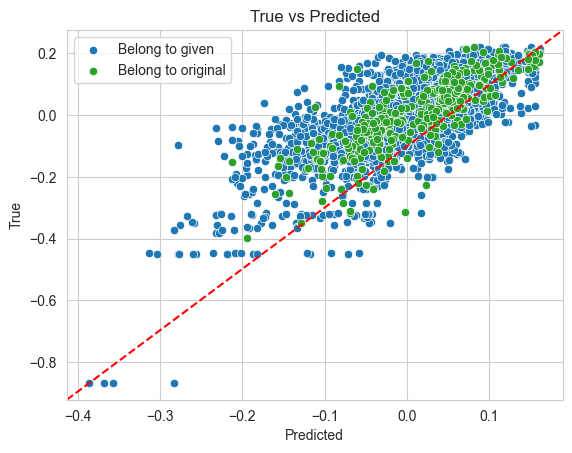

In [164]:
graph_data = {
    "data": [(X_given, y_given), (X_og, y_og)],
    "name": ['given', 'original']
}

sns.set_palette([sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
for data, name in zip(graph_data['data'], graph_data['name']):
    y = data[1]
    y_predicted = make_stacked_predictions(data[0])
    data_to_graph = pd.DataFrame({"Predicted": y_predicted, "True": y})
    sns.scatterplot(x='Predicted', y='True', label=f"Belong to {name}", data=data_to_graph)

plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='red')
plt.title("True vs Predicted")
plt.legend()
plt.show()

# Make predictions

In [165]:
df_test = df_test.drop('x_e_out', axis=1)

In [166]:
predictions = make_stacked_predictions(df_test)

In [167]:
df_test['x_e_out [-]'] = predictions

In [168]:
df_test['x_e_out [-]'].to_csv("submission.csv", index=True, index_label='id')